In [ ]:
!pip install transformers
!pip install pytorch-lightning
!pip install torchinfo

# Import lib

In [94]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import LayerNorm
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoModel, AutoTokenizer, AdamW, get_cosine_schedule_with_warmup
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score
import re
import nltk
from nltk.tokenize import word_tokenize
import math
from torchinfo import summary
from google.colab import drive
from tqdm.auto import tqdm
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Import dataset

In [44]:
! git clone https://github.com/duongnghia222/News_classification

fatal: destination path 'News_classification' already exists and is not an empty directory.


In [45]:
# Load data from CSV file
df = pd.read_csv('News_classification/data/raw_data/raw_data.csv', encoding='utf-8-sig')

# Visualize Data

In [46]:
df.tail()

,Content,Label
10391,"Một cá nhân bất ngờ mua vào 30,77 triệu cổ phi...",TTF
10392,"Chưa kịp bán ra, Chủ tịch Đỗ Quý Hải tiếp tục ...",HPX
10393,POM cho cán bộ nhân viên nghỉ việc vì dừng lò ...,POM
10394,Năm Bảy Bảy (NBB) chấp thuận cho Công ty con c...,NBB
10395,Chứng khoán Ngân hàng Sài Gòn Thương Tín (SBS)...,SBS


In [47]:
# Count the number of words in each article's content and number of times a class appear
df['Word Count'] = df['Content'].apply(lambda x: len(str(x).split()))
df['Class Count'] = df.groupby('Label')['Label'].transform('count')

# Calculate statistics for word count
df['Word Count'].describe()

count    10396.000000
mean       607.325414
std        352.123889
min         46.000000
25%        381.000000
50%        514.000000
75%        725.250000
max       4235.000000
Name: Word Count, dtype: float64

In [48]:
df.head()

,Content,Label,Word Count,Class Count
0,"Vingroup báo lãi hơn 3.600 tỷ đồng, doanh thu ...",VIC,599,108
1,HAGL Agrico (HNG) lỗ quý thứ 5 liên tiếp. Giá ...,HNG,642,65
2,"Vingroup lãi ròng 1.028 tỷ đồng nửa đầu năm, t...",VIC,577,108
3,Một doanh nghiệp khoáng sản đã vượt 153% mục t...,KSV,430,3
4,Doanh nghiệp thép từ lớn đến nhỏ đều báo lỗ qu...,HPG,1247,197


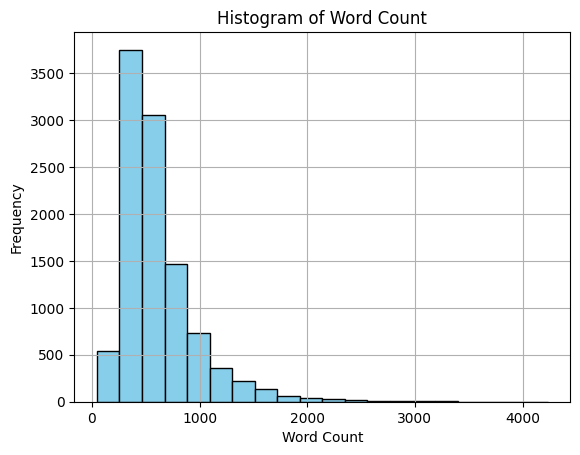

In [49]:
# Plot histogram for word count
plt.hist(df['Word Count'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [50]:
# Count the occurrence of each unique label
label_counts = df['Label'].value_counts()
print(label_counts.describe())

# Loop over each unique label and print its count
# for label, count in label_counts.items():
#     print(f"Label: {label}, Count: {count}")

count    927.000000
mean      11.214671
std       21.224713
min        1.000000
25%        1.000000
50%        3.000000
75%       11.000000
max      197.000000
Name: Label, dtype: float64


In [51]:
# extracted_df
e_df = df.loc[df['Class Count'] > 5].sort_values(by="Class Count", ascending=False)
e_df.count()

Content        9222
Label          9222
Word Count     9222
Class Count    9222
dtype: int64

In [99]:
number_of_classes = e_df['Label'].nunique()
number_of_classes

350

# Processing Dataset

## Clean text

In [53]:
with open('/content/News_classification/vietnamese-stopwords.txt', 'r', encoding='utf-8') as f:
    vietnamese_stopwords = f.read().splitlines()

vietnamese_stopwords[:10]

['a lô',
 'a ha',
 'ai',
 'ai ai',
 'ai nấy',
 'ai đó',
 'alô',
 'amen',
 'anh',
 'anh ấy']

In [54]:
def clean_text(txt):
    txt = re.sub('\s+', ' ', txt)
    txt = txt.replace('.','')
    txt = re.sub('\n', ' ', txt)
    txt = [word_tokenize(wrd) for wrd in txt.split() if wrd not in vietnamese_stopwords]
    txt = [item[0] for item in txt]
    txt = ' '.join(txt)
    return txt

clean_text(" VinFast chính thức vận hành 35 showroom xe máy điện kết hợp trung tâm trải nghiệm Vin3S tại 24 tỉnh, thành phố trên cả nước")

'VinFast thức vận hành 35 showroom xe máy điện kết hợp trung tâm trải nghiệm Vin3S 24 tỉnh thành phố'

In [98]:
e_df['Content'] = e_df['Content'].apply(clean_text)
e_df.head()

,Content,Label,Word Count,Class Count,Encode Label
1781,"Hòa Phát Lợi nhuận quý IV 59 1,5 tỷ USD Lợi nh...",HPG,675,197,122
7905,Hòa Phát lãi 4 ngàn tỷ quý 2 60 Quý 2/2022 Tập...,HPG,336,197,122
5725,Chủ tịch Trần Đình Long ( Giai đoạn thảm qua d...,HPG,977,197,122
3000,Tại Hòa Phát nâng tỷ lệ cổ tức mặc cổ đông đán...,HPG,919,197,122
2512,Hòa Phát dự kiến khởi công dự án 85000 tỷ quý ...,HPG,452,197,122


## Transform labels

In [100]:
labels_list = e_df['Label'].tolist()
print(labels_list[:10])

['HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG']


In [101]:
le = LabelEncoder()
labels = le.fit_transform(labels_list).tolist()
print(labels[-10:])

[166, 13, 121, 52, 121, 219, 151, 299, 309, 132]


In [102]:
e_df['Encode Label'] = labels
e_df.head(10)

,Content,Label,Word Count,Class Count,Encode Label
1781,"Hòa Phát Lợi nhuận quý IV 59 1,5 tỷ USD Lợi nh...",HPG,675,197,122
7905,Hòa Phát lãi 4 ngàn tỷ quý 2 60 Quý 2/2022 Tập...,HPG,336,197,122
5725,Chủ tịch Trần Đình Long ( Giai đoạn thảm qua d...,HPG,977,197,122
3000,Tại Hòa Phát nâng tỷ lệ cổ tức mặc cổ đông đán...,HPG,919,197,122
2512,Hòa Phát dự kiến khởi công dự án 85000 tỷ quý ...,HPG,452,197,122
4957,Công ty lợi nhuận Hòa Phát Sau xây dựng vốn đầ...,HPG,604,197,122
5328,Loạt đại gia ngành thép báo 'tin buồn quí đầu ...,HPG,1333,197,122
2066,Hòa Phát Formosa đứng mấy giới sản thép Năm 20...,HPG,664,197,122
1777,Hòa Phát nộp ngân sách 7400 tỷ đồng nửa đầu nă...,HPG,602,197,122
1070,"Hòa Phát Tiêu thụ thép xây dựng 2 gấp 2,3 kỳ T...",HPG,534,197,122


## Split trainset valset

In [103]:
y = e_df['Encode Label']

In [104]:
trainset, valset = train_test_split(e_df, test_size=0.2, stratify=y, random_state=42)

# Load phoBERT tokenizer

In [105]:
# Load pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2", use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [106]:
text = "công tyNếu tính GJK"
print(tokenizer.encode(text))
text = "công ty Nếu tính gjk"
print(tokenizer.encode(text))

[0, 675, 6745, 313, 294, 1276, 2136, 2260, 2]
[0, 675, 6892, 313, 294, 1529, 57202, 2]


# Hyperparameters


In [107]:
MAX_LENGTH = 256  # Adjust as needed
BATCH_SIZE = 32
N_CLASSES = number_of_classes  # Replace with your actual number of classes
EPOCHS = 30

# ArticleDataset Class

In [108]:
class ArticleDataset(Dataset):
    def __init__(self, data, labels, tokenizer, max_length=256):
        self.data = data
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        label = item.get('Encode Label')
        encoding = self.tokenizer.encode_plus(
            text=item.Content,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        # labels_tensor = torch.FloatTensor(label)
        # print(label)
        return {
            'input_ids':encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }



In [65]:
x = torch.tensor([1, 2, 3, 4, 5])
print(x.shape)

torch.Size([5])


In [109]:
a_ds = ArticleDataset(trainset, labels, tokenizer, MAX_LENGTH)
sample_item = a_ds[0]
print(len(a_ds))
sample_item.keys()


7377


dict_keys(['input_ids', 'attention_mask', 'labels'])

In [110]:
print(sample_item["input_ids"].shape)
print(tokenizer.decode(sample_item['input_ids']))
print(sample_item["labels"].shape)
print(sample_item["labels"])
print(le.inverse_transform([106]))

torch.Size([256])
<s> Hoàng Anh Gia Lai ( Con gái bầu Đức mua 1 triệu cổ phiếu Người thân lãnh đạo báo cáo kết giao dịch cổ phiếu Công ty cổ Hoàng Anh Gia Lai ( HAG – sàn HoSE đó Đoàn Hoàng Anh gái Đoàn Nguyên Đức Chủ tịch HĐQT mua 1 triệu cổ phiếu HAG nâng sở hữu 0,97 1,08 vốn lệ giao dịch thực hiện 24/10Xét hoạt động kinh doanh 6 đầu 2022 Hoàng Anh Gia Lai ghi doanh thu 150,6 kỳ 2030 tỷ đồng lợi nhuận thuế 522,84 tỷ đồng 514,53 tỷ đồng ( kỳ 8,31 tỷ đồng kỳ lợi nhuận gộp 329,8 kỳ tương ứng 357,17 tỷ đồng 465,46 tỷ đồng doanh thu tài 39,6 tương ứng 188,36 tỷ đồng 287,8 tỷ đồng chi phí tài 174,9 tương ứng 675,55 tỷ đồng 1061,79 tỷ đồng chi phí hàng quản lý doanh nghiệp bất ngờ 1003,88 tỷ đồng âm 813,07 tỷ đồng ( kỳ 190,81 tỷ đồng lợi nhuận lỗ 175,44 tỷ đồng ghi lỗ 40,79 tỷ đồng hoạt động biến động kểThực tế lợi nhuận gộp 465,46 tỷ đồng chi phí tài 1061,79 tỷ đồng Trong kỳ Công ty lãi chủ yếu ghi chi phí hàng quản lý doanh nghiệp âmCông ty thuyết minh 6 đầu bất ngờ ghi hoàn nhập </s>
tor

# Pytorch Lightning DataModule

In [111]:
class Data_Module(pl.LightningDataModule):
    def __init__(self, trainset, valset, labels, batch_size: int = 32, max_token_length: int = 256, tokenizer=None):
      super().__init__()
      self.trainset = trainset
      self.val_path = valset
      self.labels = labels
      self.batch_size = batch_size
      self.max_token_length = max_token_length
      self.tokenizer = tokenizer

    def setup(self, stage = None):
      if stage in (None, "fit"):
        self.train_dataset = ArticleDataset(self.trainset, self.labels, self.tokenizer, self.max_token_length)
        self.val_dataset = ArticleDataset(self.val_path, self.labels, self.tokenizer, self.max_token_length)
      if stage == 'predict':
        self.val_dataset = ArticleDataset(self.val_path, self.labels, self.tokenizer, self.max_token_length)

    def train_dataloader(self):
      return DataLoader(self.train_dataset, batch_size = self.batch_size, num_workers=2, shuffle=True)

    def val_dataloader(self):
      return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=2, shuffle=False)

    def predict_dataloader(self):
      return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=2, shuffle=False)

# Create PyTorch lightning DataLoader

In [112]:
# Create PyTorch lightning DataLoader
data_loader = Data_Module(trainset, valset, labels, BATCH_SIZE, MAX_LENGTH, tokenizer)
data_loader.setup()
len(data_loader.train_dataloader())

231

# Model architecture

In [113]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [114]:
class ArticleClassifier(pl.LightningModule):
    def __init__(self, config: dict, freeze_bert=False):
        super().__init__()
        self.config = config
        self.bert = AutoModel.from_pretrained(config['model_name'], return_dict = True)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        print(self.bert.config.hidden_size)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 128)  # Adjusted the input size to match the bert's hidden size
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 256)
        self.dropout2 = nn.Dropout(0.4)
        self.layer_norm = LayerNorm(256)
        self.output = nn.Linear(256, self.config['n_labels'])
        self.loss = nn.CrossEntropyLoss()



    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids, attention_mask).pooler_output
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.layer_norm(x)
        logits = self.output(x)  # Remove softmax activation here
        return logits


    # def training_step(self, batch, batch_idx):
    #     input_ids = batch["input_ids"]
    #     attention_mask = batch["attention_mask"]
    #     labels = batch["labels"]
    #     logits = self(input_ids, attention_mask)
    #     print("ts-l", logits.requires_grad)
    #     print("ts-la", labels.requires_grad)
    #     loss = self.loss(logits, labels)
    #     self.log("train_loss", loss, prog_bar=True, logger=True)
    #     return {"loss": loss, "predictions": logits, "labels": labels}


    # def validation_step(self, batch, batch_idx):
    #     input_ids = batch["input_ids"]
    #     attention_mask = batch["attention_mask"]
    #     labels = batch["labels"]
    #     logits = self(input_ids, attention_mask)
    #     loss = self.loss(logits, labels)
    #     self.log("val_loss", loss, prog_bar=True, logger=True)
    #     return loss


    # def test_step(self, batch, batch_idx):
    #     input_ids = batch["input_ids"]
    #     attention_mask = batch["attention_mask"]
    #     labels = batch["labels"]
    #     logits = self(input_ids, attention_mask)
    #     loss = self.loss(logits, labels)
    #     self.log("test_loss", loss, prog_bar=True, logger=True)
    #     return loss


    # def configure_optimizers(self):
    #     optimizer = AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
    #     total_steps = self.config['train_size']/self.config['batch_size']
    #     warmup_steps = math.floor(total_steps * self.config['warmup'])
    #     warmup_steps = math.floor(total_steps * self.config['warmup'])
    #     scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    #     return [optimizer],[scheduler]

# Initialize Model

## Model configuration

In [115]:
config = {
    'model_name': 'vinai/phobert-base-v2',
    'n_labels': number_of_classes,
    'batch_size': BATCH_SIZE,
    'lr': 1e-3,
    'warmup': 0.15,
    'train_size': len(data_loader.train_dataloader()),
    'weight_decay': 0.01,
    'n_epochs': 100
}

## Create model

In [116]:
# Initialize our classifier
model = ArticleClassifier(config, freeze_bert=False)
model = model.to(device)

Some weights of the model checkpoint at vinai/phobert-base-v2 were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


768


In [ ]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

In [75]:
idx=0
input_ids_ = a_ds.__getitem__(idx)['input_ids']
attention_mask_ = a_ds.__getitem__(idx)['attention_mask']
labels_ = a_ds.__getitem__(idx)['labels']
model.cpu()
output = model(input_ids_.unsqueeze(dim=0), attention_mask_.unsqueeze(dim=0))
print(labels_.shape, output.shape)

torch.Size([]) torch.Size([1, 350])


In [76]:
test_batch = next(iter(data_loader.train_dataloader()))
test_batch_input_ids = test_batch['input_ids']
print(test_batch_input_ids.shape)
output = model(test_batch['input_ids'], test_batch['attention_mask'])
print(labels_.shape, output.shape)

torch.Size([32, 256])
torch.Size([]) torch.Size([32, 350])


In [77]:
test_batch_labels = test_batch['labels']
test_batch_labels.shape

torch.Size([32])

# Model Summary

In [117]:
summary(model)

Layer (type:depth-idx)                                       Param #
ArticleClassifier                                            --
├─RobertaModel: 1-1                                          --
│    └─RobertaEmbeddings: 2-1                                --
│    │    └─Embedding: 3-1                                   49,152,768
│    │    └─Embedding: 3-2                                   198,144
│    │    └─Embedding: 3-3                                   768
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─RobertaEncoder: 2-2                                   --
│    │    └─ModuleList: 3-6                                  85,054,464
│    └─RobertaPooler: 2-3                                    --
│    │    └─Linear: 3-7                                      590,592
│    │    └─Tanh: 3-8                                        --
├─Linear: 1-2                                                98,432
├


# Train Model

In [78]:
def train_model(model, data_loader, config):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

    total_steps = config['train_size']/config['batch_size']
    warmup_steps = math.floor(total_steps * config['warmup'])
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    best_valid_loss = float('inf')
    early_stopping_counter = 0
    early_stopping_limit = 5  # Number of epochs with no improvement after which training will be stopped
    model_path = 'best_model.pt'  # path where best model will be saved

    progress_bar = tqdm(range(config['n_epochs']), desc="Training", total=config['n_epochs'])

    for epoch in progress_bar:
        model.train()
        total_loss = 0

        for batch in data_loader.train_dataloader():
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, attention_mask)

            loss = model.loss(logits, labels)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(data_loader.train_dataloader())

        # Start the validation
        model.eval()

        predictions , true_labels = [], []
        total_eval_loss = 0

        for batch in data_loader.val_dataloader():
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            with torch.no_grad():
                logits = model(input_ids, attention_mask)

            loss = model.loss(logits, labels)
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            labels = labels.to('cpu').numpy()

            # Store predictions and true labels
            predictions.append(logits)
            true_labels.append(labels)

        # Calculate the average loss over all of the batches
        avg_val_loss = total_eval_loss / len(data_loader.val_dataloader())

        # Calculate validation accuracy
        predictions = np.concatenate(predictions, axis=0)
        true_labels = np.concatenate(true_labels, axis=0)
        val_accuracy = accuracy_score(true_labels, np.argmax(predictions, axis=1))

        # Update progress bar
        progress_bar.set_postfix({'train_loss': avg_train_loss, 'valid_loss': avg_val_loss, 'valid_acc': val_accuracy})

        # save model if validation loss has decreased
        if avg_val_loss < best_valid_loss:
            best_valid_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            early_stopping_counter = 0  # reset counter
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_limit:
                print(f'EarlyStopping counter: {early_stopping_counter} out of {early_stopping_limit}')
                if early_stopping_counter >= early_stopping_limit:
                    print('Early stopping, stopping training')
                    break  # break out from the training loop


In [79]:
train_model(model, data_loader, config)

Training:   0%|          | 0/100 [00:00<?, ?it/s]

EarlyStopping counter: 5 out of 5
Early stopping, stopping training


# Predict

In [88]:
def test_model(model, data_loader):
    # model.load_state_dict(torch.load('best_model.pt'))
    model.eval()

    predictions, true_labels = [], []

    for batch in data_loader.val_dataloader():
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad():
            logits = model(input_ids, attention_mask)

        logits = logits.detach().cpu().numpy()
        labels = labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(labels)

    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)

    # Calculate accuracy
    test_accuracy = accuracy_score(true_labels, np.argmax(predictions, axis=1))

    print(f'Test Accuracy: {test_accuracy}')

    return test_accuracy

In [89]:
test_model(model, data_loader)

Test Accuracy: 0.5186991869918699


0.5186991869918699

# Naive Bayes

In [82]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [83]:
test_content = e_df.iloc[1].get("Content")
print(test_content)
print("------------------------------------------------------------")
sentences = nltk.tokenize.sent_tokenize(test_content)
for s in sentences:
  print(s)

Hòa Phát lãi 4 ngàn tỷ trong quý 2, giảm gần 60%. Quý 2/2022, Tập đoàn Hòa Phát (HOSE: HPG) ghi nhận lợi nhuận sau thuế đạt 4,023 tỷ đồng, giảm 58%.  Lũy kế 6 tháng đầu năm, Hòa Phát ghi nhận 82 ngàn tỷ đồng doanh thu và 12.2 ngàn tỷ lợi nhuận sau thuế, tương ứng giảm 27% so với cùng kỳ năm trước, qua đó hoàn thành 46% kế hoạch năm.  Trong quý 2, sản lượng bán hàng phôi thép, thép xây dựng, thép cuộn cán nóng đạt 1.8 triệu tấn, trong đó có gần 380,000 tấn thép xây dựng xuất khẩu. Tiêu thụ ống thép, tôn mạ lần lượt đạt 159,000 và 75,000 tấn. Hòa Phát vẫn giữ vị thế thị phần số 1 Việt Nam về thép xây dựng (36.2%) và ống thép (28.8%). Lũy kế 6 tháng đầu năm, Tập đoàn Hòa Phát đã sản xuất 4.3 triệu tấn thép thô, tăng 8% so với cùng kỳ. Tiêu thụ thép xây dựng, phôi thép và HRC đạt gần 4 triệu tấn, tăng 6% so với cùng kỳ. Trong đó, thép xây dựng là 2.38 triệu tấn, tăng 29% so với 6 tháng đầu năm 2021. Sau nửa năm, bán hàng HRC của Hòa Phát ghi nhận 1.4 triệu tấn, tăng 7% so với cùng kỳ. Sản 

In [84]:
train_data, test_data, train_labels, test_labels = train_test_split(e_df['Content'], e_df['Encode Label'], random_state=42)

In [85]:
model_nb = make_pipeline(CountVectorizer(), MultinomialNB())

In [86]:
# Train the model
model_nb.fit(train_data, train_labels)


Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [87]:
# Predict the labels of the test set
predictions = model_nb.predict(test_data)

# Print out the accuracy
print(f"Accuracy: {accuracy_score(test_labels, predictions)}")

Accuracy: 0.4679098005203816
